## Build Workflow for cleaning DICOM IMAGES

In [ ]:
import pandas as pd
import numpy as np
import tqdm
import pydicom
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image

In [ ]:
from inference.inference_yolo_models import yolo_predict
from clean.clean import clean_image

In [ ]:
def yolo_predict(model:YOLO, image:Image.Image, device: str) -> Image.Image:
    """Predicts bounding boxes on images using a YOLO model.

    Args:
        model (nn.Module): YOLO model
        img_paths (Image): PIL Image object
        device (str): Device to run the model on
    Returns:
        image (Image): PIL Image object

    """
    # tta_preds = []

    # for image_dir in tqdm.tqdm(img_paths, desc="predicting with YOLO"):
    # image = Image.open(image_dir).convert("RGB")
    # image = np.array(image)

    predictions = model(
        image, conf=0.4, device=device, verbose=False, augment=False,
        )

    final_predictions = []
    for r in predictions:
        boxes = r.boxes
        for box in boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            xyxy = box.xyxy[0].tolist()

            class_name = model.names[cls]
            xmin, ymin, xmax, ymax = xyxy
            final_predictions.append(
                {
                    "class": class_name,                                                                                                                                                                                                                wwwwwwwwwewwww  q
                    "confidence": conf,
                    "ymin": ymin,
                    "xmin": xmin,
                    "ymax": ymax,
                    "xmax": xmax,
                },
            )

        if len(boxes) == 0:
            final_predictions.append(
                {
                    "class": "NEG",
                    "confidence": 0,
                    "ymin": 0,
                    "xmin": 0,
                    "ymax": 0,
                    "xmax": 0,
                },
            )

    return final_predictions

In [ ]:
# Load a DICOM file
ds = pydicom.dcmread('DICOM-TIFF format/DSIA001_dicom.dcm')

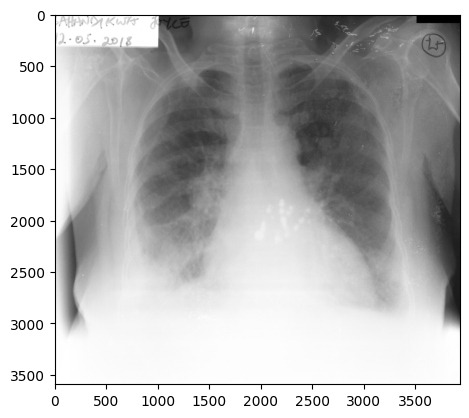

In [ ]:
# Access the pixel data and plot an image
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
plt.show()

In [ ]:
type(ds.pixel_array)

numpy.ndarray

In [ ]:
model = YOLO("phi_models/best.pt")
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [ ]:
num_params = sum(p.numel() for p in model.parameters())
num_params/1e6

2.59023

In [ ]:
bboxes = yolo_predict(model, ds.pixel_array, "cpu")
bboxes

[{'class': 'Age',
  'confidence': 0.8458648324012756,
  'ymin': 9.512916564941406,
  'xmin': 0.7654587626457214,
  'ymax': 355.4942626953125,
  'xmax': 1321.8843994140625}]

In [ ]:
new_image = clean_image(ds.pixel_array, bboxes)

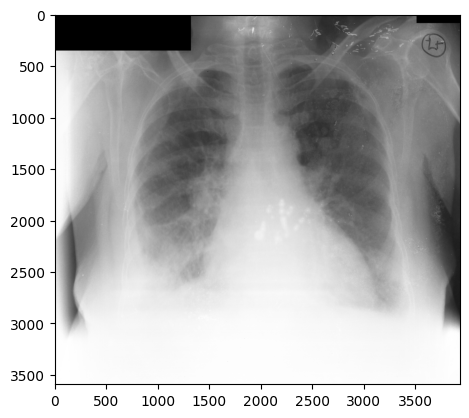

In [ ]:
# plot the new image
plt.imshow(new_image, cmap=plt.cm.bone)
plt.show()

In [ ]:
# Change the pixel data and save the new DICOM file
ds.PixelData = new_image.tobytes()

In [ ]:
from pydicom import dcmread
from pydicom.pixel_data_handlers.util import get_expected_length
from pydicom.uid import ExplicitVRLittleEndian

if (
    ds.file_meta.TransferSyntaxUID.is_compressed
    and get_expected_length(ds) == len(ds.PixelData)
):
    ds.file_meta.TransferSyntaxUID = ExplicitVRLittleEndian

ds.save_as("out.dcm")

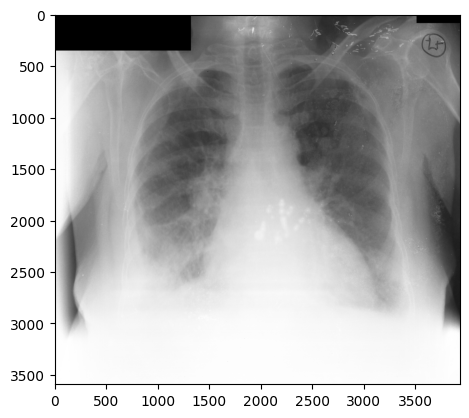

In [ ]:
new_dicom = pydicom.dcmread("out.dcm")
plt.imshow(new_dicom.pixel_array, cmap=plt.cm.bone)
plt.show()